In [ ]:
# Install required libraries
!pip install -q rasterio tqdm geopandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.5 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 21 annual GeoTIFF files:
Chittagong_Annual_2002.tif
Chittagong_Annual_2003.tif
Chittagong_Annual_2004.tif
Chittagong_Annual_2005.tif
Chittagong_Annual_2006.tif

Inspecting Chittagong_Annual_2002.tif:
Number of bands: 4
Shape of first band: (393, 240)
NoData value: None


Processing GeoTIFFs: 100%|██████████| 21/21 [00:02<00:00,  8.35it/s]



Time-series dataset summary:
Time range: 2002 to 2022
Total pixels: 1,980,720
Unique locations: 94,320

Missing values:
longitude          0
latitude           0
year               0
precip       1253763
lst          1257083
eto          1313064
ndvi         1246352
dtype: int64

Saved processed data to: /content/drive/MyDrive/chittagong_timeseries.csv


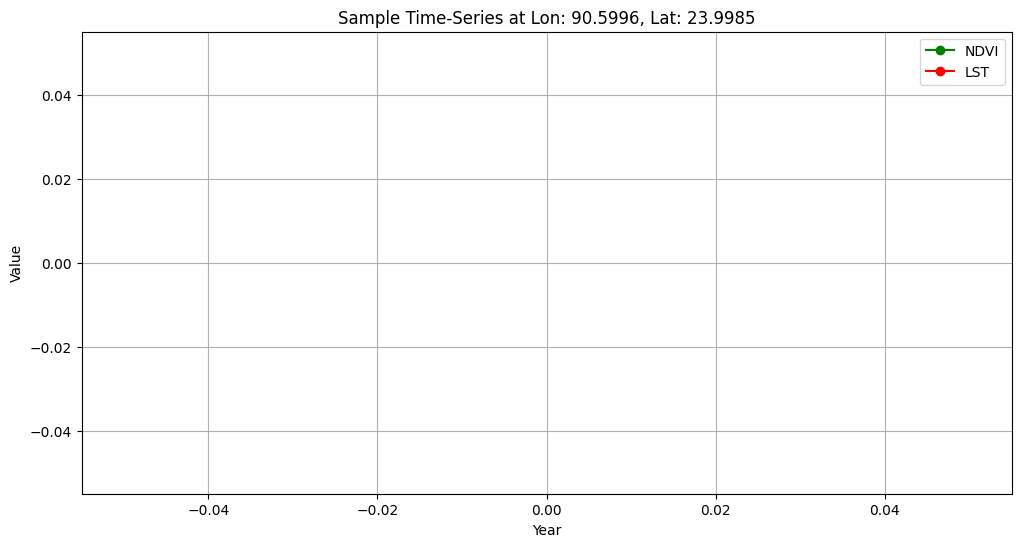

In [ ]:
# Import libraries
from google.colab import drive
import os
import glob
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Set path to your GeoTIFF folder (MODIFY THIS)
geotiff_folder = '/content/drive/MyDrive/GEE_Exports/'  # Change to your folder
os.chdir(geotiff_folder)

# 3. List and verify GeoTIFF files
geotiffs = sorted(glob.glob('Chittagong_Annual_*.tif'))
print(f"Found {len(geotiffs)} annual GeoTIFF files:")
print("\n".join(geotiffs[:5]))  # Show first 5 files

# 4. First inspect one file to understand its structure
with rasterio.open(geotiffs[0]) as src:
    print(f"\nInspecting {geotiffs[0]}:")
    print(f"Number of bands: {src.count}")
    print(f"Shape of first band: {src.read(1).shape}")
    print(f"NoData value: {src.nodata}")

# 5. Modified processing function
def process_geotiff(file):
    try:
        year = int(file.split('_')[-1].split('.')[0])
        with rasterio.open(file) as src:
            # Read first band to get dimensions
            sample_band = src.read(1)
            rows, cols = np.where(sample_band != src.nodata)

            # Read all data for valid pixels only
            data = []
            for band in range(1, src.count + 1):
                band_data = src.read(band)
                data.append(band_data[rows, cols])

            # Get coordinates for valid pixels
            xs, ys = rasterio.transform.xy(src.transform, rows, cols)

            # Create DataFrame
            df = pd.DataFrame({
                'longitude': xs,
                'latitude': ys,
                'year': year,
                'precip': data[0],
                'lst': data[1],
                'eto': data[2],
                'ndvi': data[3]
            })
        return df
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        return None

# 6. Process all files with progress bar
all_data = []
for file in tqdm(geotiffs, desc="Processing GeoTIFFs"):
    result = process_geotiff(file)
    if result is not None:
        all_data.append(result)

# Check if we got any data
if not all_data:
    raise ValueError("No files were processed successfully. Check the file structure.")

# 7. Combine into single DataFrame
ts_df = pd.concat(all_data, ignore_index=True)
ts_df = ts_df.sort_values(['longitude', 'latitude', 'year'])

# 8. Data validation
print("\nTime-series dataset summary:")
print(f"Time range: {ts_df['year'].min()} to {ts_df['year'].max()}")
print(f"Total pixels: {len(ts_df):,}")
print(f"Unique locations: {ts_df[['longitude', 'latitude']].drop_duplicates().shape[0]:,}")
print("\nMissing values:")
print(ts_df.isnull().sum())

# 9. Save processed data
output_path = '/content/drive/MyDrive/chittagong_timeseries.csv'
ts_df.to_csv(output_path, index=False)
print(f"\nSaved processed data to: {output_path}")

# 10. Visualize sample time-series
if not ts_df.empty:
    sample_loc = ts_df.sample(1)[['longitude', 'latitude']].iloc[0]
    sample_ts = ts_df[
        (ts_df['longitude'] == sample_loc['longitude']) &
        (ts_df['latitude'] == sample_loc['latitude'])
    ].sort_values('year')

    plt.figure(figsize=(12, 6))
    plt.plot(sample_ts['year'], sample_ts['ndvi'], 'g-o', label='NDVI')
    plt.plot(sample_ts['year'], sample_ts['lst'], 'r-o', label='LST')
    plt.title(f"Sample Time-Series at Lon: {sample_loc['longitude']:.4f}, Lat: {sample_loc['latitude']:.4f}")
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No data available for visualization")

In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
import pandas as pd
import io

# Upload the CSV file manually
uploaded = files.upload()

# Load into DataFrame
df = pd.read_csv(io.BytesIO(uploaded['chittagong_timeseries.csv']))

# Display the data
df.head()


Saving chittagong_timeseries.csv to chittagong_timeseries.csv


,longitude,latitude,year,precip,lst,eto,ndvi
0,90.536706,20.746591,2002,NaN,NaN,NaN,NaN
1,90.536706,20.746591,2003,NaN,NaN,NaN,NaN
2,90.536706,20.746591,2004,NaN,NaN,NaN,NaN
3,90.536706,20.746591,2005,NaN,NaN,NaN,NaN
4,90.536706,20.746591,2006,NaN,NaN,NaN,NaN


In [ ]:
df.head()

,longitude,latitude,year,precip,lst,eto,ndvi
0,90.536706,20.746591,2002,NaN,NaN,NaN,NaN
1,90.536706,20.746591,2003,NaN,NaN,NaN,NaN
2,90.536706,20.746591,2004,NaN,NaN,NaN,NaN
3,90.536706,20.746591,2005,NaN,NaN,NaN,NaN
4,90.536706,20.746591,2006,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980720 entries, 0 to 1980719
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   longitude  float64
 1   latitude   float64
 2   year       int64  
 3   precip     float64
 4   lst        float64
 5   eto        float64
 6   ndvi       float64
dtypes: float64(6), int64(1)
memory usage: 105.8 MB


In [ ]:
df.describe()

,longitude,latitude,year,precip,lst,eto,ndvi
count,1.980720e+06,1.980720e+06,1.980720e+06,726957.000000,723637.000000,667656.000000,734368.000000
mean,9.161019e+01,2.250729e+01,2.012000e+03,2854.761735,27.281118,662.644346,0.592288
std,6.223658e-01,1.019130e+00,6.055302e+00,569.255097,1.073970,216.393456,0.182188
min,9.053671e+01,2.074659e+01,2.002000e+03,1666.285032,22.495143,0.300000,-0.199000
25%,9.107345e+01,2.162694e+01,2.007000e+03,2431.964410,26.589474,478.700000,0.516100
50%,9.161019e+01,2.250729e+01,2.012000e+03,2842.190849,27.337273,648.700000,0.620300
75%,9.214694e+01,2.338764e+01,2.017000e+03,3204.444929,28.004545,841.300000,0.729500
max,9.268368e+01,2.426799e+01,2.022000e+03,5059.807258,34.350000,1571.100000,0.896800


In [ ]:
df.isnull().sum()

,0
longitude,0
latitude,0
year,0
precip,1253763
lst,1257083
eto,1313064
ndvi,1246352


Dataset loaded successfully from the specified path.

--- 2. Basic Information ---
DataFrame Shape: (1980720, 7)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980720 entries, 0 to 1980719
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   longitude  float64
 1   latitude   float64
 2   year       int64  
 3   precip     float64
 4   lst        float64
 5   eto        float64
 6   ndvi       float64
dtypes: float64(6), int64(1)
memory usage: 105.8 MB

First 5 rows of the DataFrame:
   longitude   latitude  year  precip  lst  eto  ndvi
0  90.536706  20.746591  2002     NaN  NaN  NaN   NaN
1  90.536706  20.746591  2003     NaN  NaN  NaN   NaN
2  90.536706  20.746591  2004     NaN  NaN  NaN   NaN
3  90.536706  20.746591  2005     NaN  NaN  NaN   NaN
4  90.536706  20.746591  2006     NaN  NaN  NaN   NaN

--- 3. Descriptive Statistics ---
          longitude      latitude          year         precip            lst  \
count  1.980720e+0

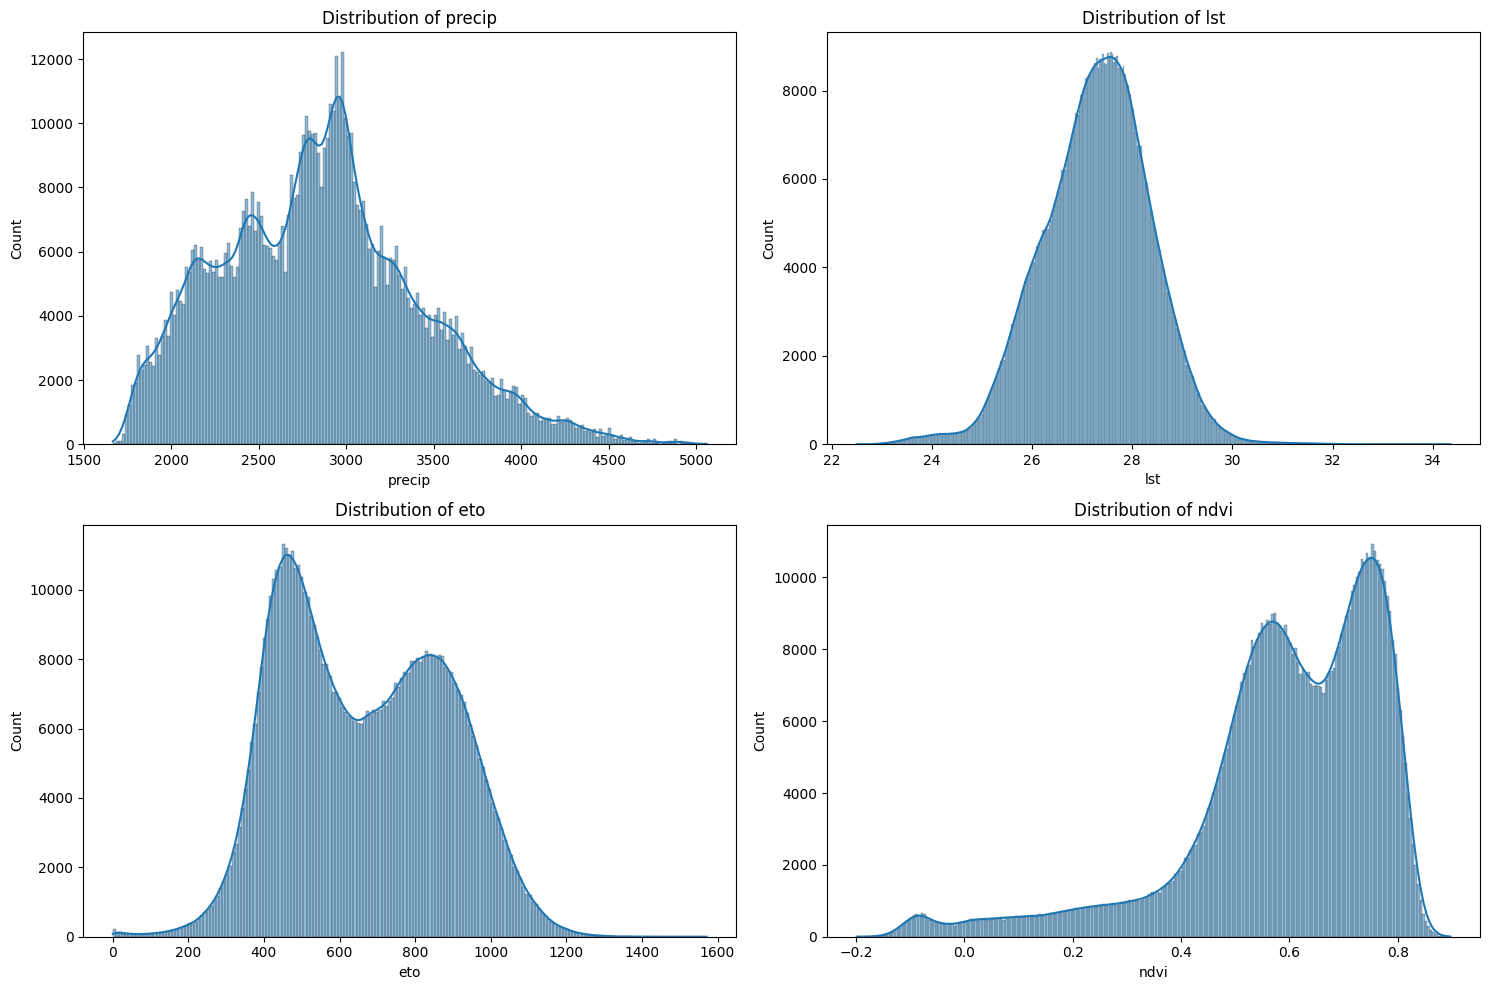

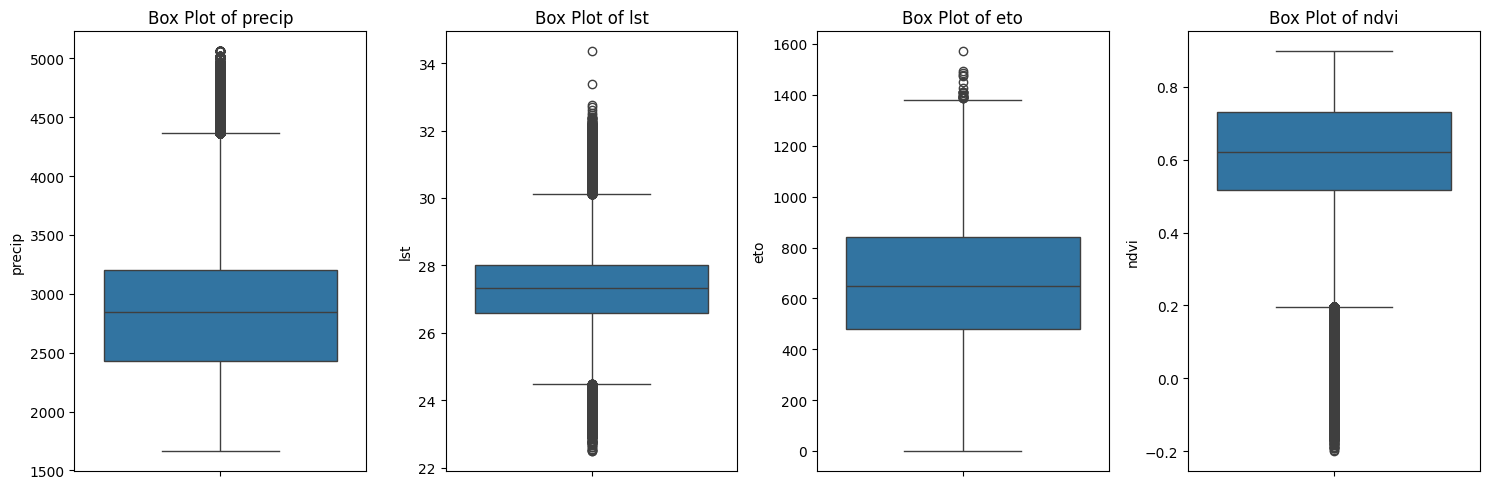


--- 6. Correlation Matrix Heatmap ---


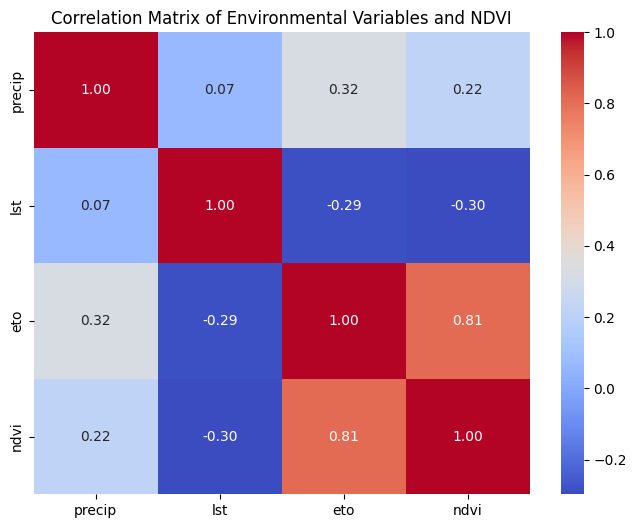


--- 7. Time-Series Trends (Average per Year) ---


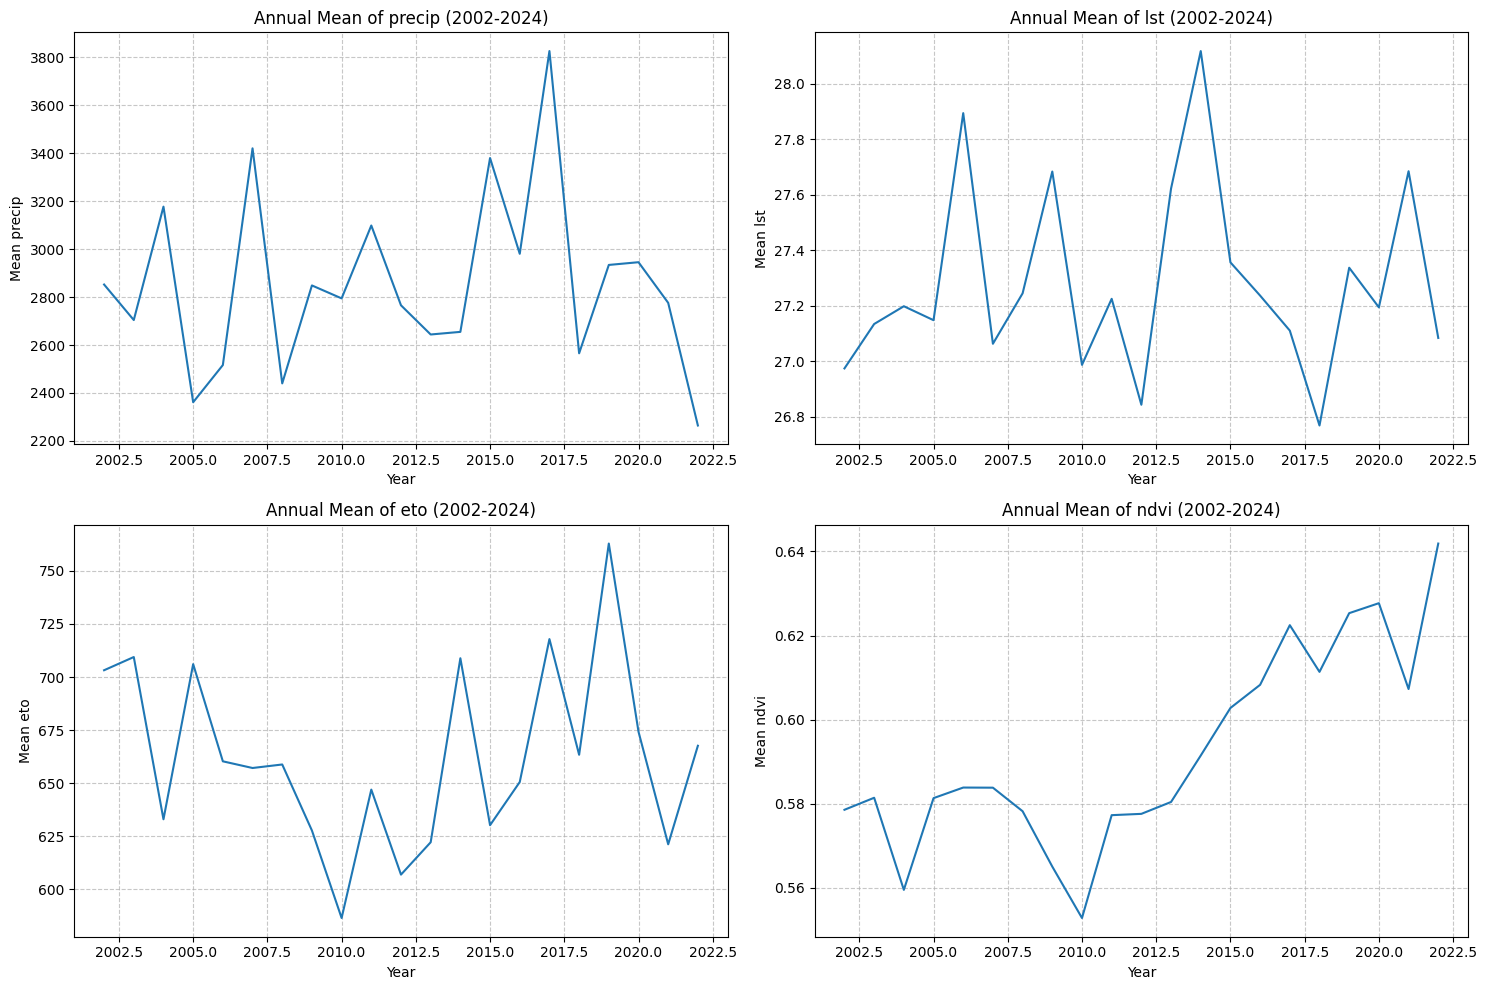


--- EDA Code Provided ---
Please run this code with your actual data path and share the full output, including the plots.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load the Dataset ---
# IMPORTANT: Please replace 'path/to/your/GEE_Exported_Data.csv' with the actual path to your CSV file.
# Example: df = pd.read_csv('Chittagong_Monthly_Climate_Data_ML_2002_2024.csv')
try:
    df = pd.read_csv('/content/chittagong_timeseries.csv') # <--- REPLACE THIS PATH
    print("Dataset loaded successfully from the specified path.")
except FileNotFoundError:
    print("Error: Dataset file not found at the specified path.")
    print("Please ensure the CSV file is in the correct directory or provide the full correct path.")
    print("To proceed, please correct the path in the code and rerun.")
    # Exit or handle the error gracefully if the actual file isn't found
    # For now, we'll exit to prevent running EDA on a dummy dataset if the user intended their real data.
    exit() # This will stop the execution if the file is not found.


print("\n--- 2. Basic Information ---")
print("DataFrame Shape:", df.shape)
print("\nDataFrame Info:")
df.info()
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

print("\n--- 3. Descriptive Statistics ---")
print(df.describe())

print("\n--- 4. Checking for Missing Values ---")
missing_values = df.isnull().sum()
print("Number of missing values per column:")
print(missing_values)
print("\nPercentage of missing values per column:")
print((missing_values / len(df)) * 100)

print("\n--- 5. Visualizing Distributions of Key Variables (Histograms and Box Plots) ---")
# Select numerical columns for distribution plots, excluding longitude, latitude, year for now
numerical_cols = ['precip', 'lst', 'eto', 'ndvi']

# For very large datasets, plotting all points can be slow or memory-intensive.
# If your actual dataset (1.9 million rows) causes issues, you might want to sample it for plotting:
# df_sampled = df.sample(n=min(100000, len(df)), random_state=42) if len(df) > 100000 else df.copy()
# For now, we'll try to plot on the full dataset, but if it's too slow/heavy, uncomment the sampling line.
df_plot = df.copy()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_plot[col].dropna(), kde=True) # dropna to handle NaNs for plotting
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=df_plot[col].dropna()) # dropna to handle NaNs for plotting
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

print("\n--- 6. Correlation Matrix Heatmap ---")
# Drop rows with NaNs for correlation calculation, as correlation is sensitive to NaNs
# This will only calculate correlation for rows where all selected columns are non-null.
correlation_matrix = df[numerical_cols].dropna().corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Environmental Variables and NDVI')
plt.show()

print("\n--- 7. Time-Series Trends (Average per Year) ---")
# Group by year and calculate the mean for each variable
# This aggregates available data per year. If missing data imputation is done later, trends might change.
df_annual_mean = df.groupby('year')[['precip', 'lst', 'eto', 'ndvi']].mean().reset_index()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.lineplot(data=df_annual_mean, x='year', y=col)
    plt.title(f'Annual Mean of {col} (2002-2024)')
    plt.xlabel('Year')
    plt.ylabel(f'Mean {col}')
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- EDA Code Provided ---")
print("Please run this code with your actual data path and share the full output, including the plots.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



try:
    # Load the dataset using the determined file_path
    df = pd.read_csv('/content/chittagong_timeseries.csv')
    print("Dataset loaded successfully for interpolation.")
except FileNotFoundError:
    print(f"Error: Dataset file not found at: {file_path}")
    print("Please ensure the CSV file is in the correct location and the 'file_path' variable is set correctly.")
    print("Cannot proceed with interpolation without the dataset. Please correct the path and rerun.")
    # Exit or handle the error gracefully as we cannot proceed without the data
    exit() # This will stop the execution if the file is not found.


print("\n--- Original Missing Values ---")
print(df.isnull().sum())

# --- 2. Prepare for Interpolation ---
# Columns to be interpolated
numerical_cols = ['precip', 'lst', 'eto', 'ndvi']

# It's crucial to sort the DataFrame by longitude, latitude, and year
# to ensure proper time-series interpolation within each unique spatial point.
df_sorted = df.sort_values(by=['longitude', 'latitude', 'year']).copy()

# --- 3. Perform Grouped Time-Series Interpolation ---
# Group by longitude and latitude, then apply linear interpolation to each group's time series.
# This fills NaNs for each unique spatial point over time.
print(f"\nPerforming linear interpolation for {', '.join(numerical_cols)} within each unique (longitude, latitude) point over time...")

for col in numerical_cols:
    df_sorted[col] = df_sorted.groupby(['longitude', 'latitude'])[col].transform(
        lambda group: group.interpolate(method='linear', limit_direction='both', limit_area='inside')
    )

# Explanation of parameters for `interpolate()`:
# `method='linear'`: Fills values linearly between valid data points.
# `limit_direction='both'`: Attempts to fill NaNs both forward and backward within a group's series.
# `limit_area='inside'`: Only fills NaNs that are strictly *between* valid observations.
#                       It does NOT extrapolate to fill NaNs at the very beginning or end of a series
#                       if they are outside the range of known values.

# --- 4. Check for Remaining Missing Values After Grouped Interpolation ---
print("\n--- Missing Values After Grouped Interpolation Pass ---")
remaining_missing_values = df_sorted.isnull().sum()
print(remaining_missing_values)
print("\nPercentage of remaining missing values per column:")
print((remaining_missing_values / len(df_sorted)) * 100)

# --- 5. Final Pass for Any Remaining NaNs (Column-wise Linear Interpolation) ---
# If after the grouped interpolation there are still NaNs, it means either:
# a) A whole time series for a specific (lon, lat) had all NaNs, so no interpolation was possible.
# b) NaNs existed at the very beginning or end of a series, and `limit_area='inside'` prevented extrapolation.
# For such rare cases, a final column-wise interpolation (extrapolating if needed) is applied as a fallback.
# If even after this, NaNs remain (e.g., if an entire column was NaN), a mean/median fill might be needed.
print("\n--- Final Pass for Any Remaining NaNs (Column-wise Linear Interpolation) ---")
for col in numerical_cols:
    if df_sorted[col].isnull().any():
        print(f"Applying final column-wise linear interpolation for {col} (including extrapolation)...")
        # Use `limit_direction='both'` without `limit_area` to allow extrapolation if needed
        df_sorted[col] = df_sorted[col].interpolate(method='linear', limit_direction='both')

        # Check again if any NaNs remain (e.g., if a column was entirely NaN originally)
        if df_sorted[col].isnull().any():
            print(f"Warning: Column '{col}' still has NaNs after all interpolation steps. This might happen if the entire column was originally missing values. Consider filling with a global mean/median if appropriate for your analysis: `df_sorted['{col}'].fillna(df_sorted['{col}'].mean(), inplace=True)`")
            # Example of a final fill with mean if needed:
            # df_sorted[col].fillna(df_sorted[col].mean(), inplace=True) # Uncomment if you want this fallback

print("\n--- Missing Values After Final Interpolation Pass ---")
final_missing_values = df_sorted.isnull().sum()
print(final_missing_values)
print("\nPercentage of final remaining missing values per column:")
print((final_missing_values / len(df_sorted)) * 100)

# --- 6. Display a sample of the interpolated data ---
print("\n--- Sample of DataFrame after Interpolation ---")
print(df_sorted.head())
print(df_sorted.tail())

print("\n--- Interpolation Code Provided ---")
print("Please run this code in your Google Colab notebook. After successful execution, the 'df_sorted' DataFrame will contain your interpolated data.")

Dataset loaded successfully for interpolation.

--- Original Missing Values ---
longitude          0
latitude           0
year               0
precip       1253763
lst          1257083
eto          1313064
ndvi         1246352
dtype: int64

Performing linear interpolation for precip, lst, eto, ndvi within each unique (longitude, latitude) point over time...

--- Missing Values After Grouped Interpolation Pass ---
longitude          0
latitude           0
year               0
precip       1253763
lst          1257081
eto          1312775
ndvi         1245431
dtype: int64

Percentage of remaining missing values per column:
longitude     0.000000
latitude      0.000000
year          0.000000
precip       63.298346
lst          63.465861
eto          66.277667
ndvi         62.877691
dtype: float64

--- Final Pass for Any Remaining NaNs (Column-wise Linear Interpolation) ---
Applying final column-wise linear interpolation for precip (including extrapolation)...
Applying final column-wise li

In [ ]:
df_sorted.head()

,longitude,latitude,year,precip,lst,eto,ndvi
0,90.536706,20.746591,2002,2209.311025,27.201892,461.1,0.4389
1,90.536706,20.746591,2003,2209.311025,27.201892,461.1,0.4389
2,90.536706,20.746591,2004,2209.311025,27.201892,461.1,0.4389
3,90.536706,20.746591,2005,2209.311025,27.201892,461.1,0.4389
4,90.536706,20.746591,2006,2209.311025,27.201892,461.1,0.4389


In [ ]:
df_sorted.isnull().sum()

,0
longitude,0
latitude,0
year,0
precip,0
lst,0
eto,0
ndvi,0


In [ ]:
df_sorted.to_csv('/content/df_sorted.csv', index=False)

In [ ]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980720 entries, 0 to 1980719
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   longitude  float64
 1   latitude   float64
 2   year       int64  
 3   precip     float64
 4   lst        float64
 5   eto        float64
 6   ndvi       float64
dtypes: float64(6), int64(1)
memory usage: 105.8 MB


In [ ]:
df_sorted.columns

Index(['longitude', 'latitude', 'year', 'precip', 'lst', 'eto', 'ndvi'], dtype='object')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
24759/24759 ━━━━━━━━━━━━━━━━━━━━ 150s 6ms/step - loss: 0.0275 - val_loss: 0.0108
Epoch 2/10
24759/24759 ━━━━━━━━━━━━━━━━━━━━ 195s 6ms/step - loss: 0.0180 - val_loss: 0.0111
Epoch 3/10
24759/24759 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - loss: 0.0160 - val_loss: 0.0113
Epoch 4/10
24759/24759 ━━━━━━━━━━━━━━━━━━━━ 146s 6ms/step - loss: 0.0151 - val_loss: 0.0113
Epoch 5/10
24759/24759 ━━━━━━━━━━━━━━━━━━━━ 202s 6ms/step - loss: 0.0146 - val_loss: 0.0124
Epoch 6/10
24759/24759 ━━━━━━━━━━━━━━━━━━━━ 202s 6ms/step - loss: 0.0141 - val_loss: 0.0132
12380/12380 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


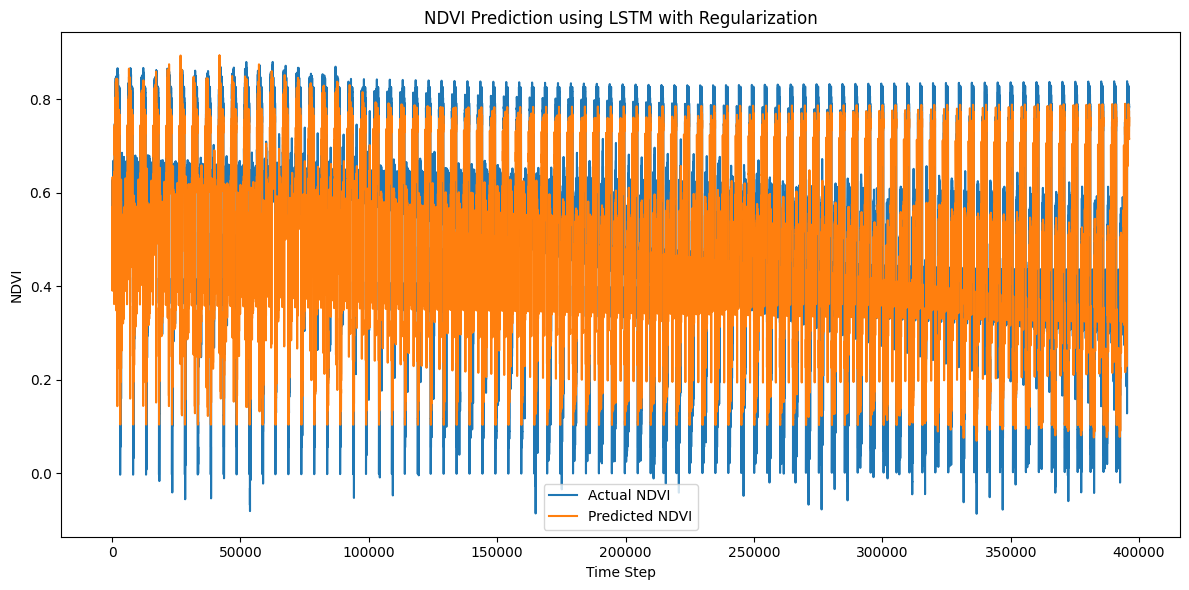

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 1: Sort and preprocess data
df_sorted = df_sorted.sort_values(by=['latitude', 'longitude', 'year'])

# Select features and target
features = ['precip', 'lst', 'eto']
target = 'ndvi'

# Normalize features
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df_sorted[features])
y_scaled = scaler_y.fit_transform(df_sorted[[target]])

# Combine into one dataframe
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled[target] = y_scaled

# Step 2: Create time series sequences
def create_sequences(data, window_size):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data.iloc[i:i+window_size][features].values)
        y_seq.append(data.iloc[i+window_size][target])
    return np.array(X_seq), np.array(y_seq)

window_size = 5
X, y = create_sequences(df_scaled, window_size)

# Step 3: Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 4: Define LSTM model with L2 regularization, Dropout, and EarlyStopping
model = Sequential([
    LSTM(64, input_shape=(window_size, len(features)),
         kernel_regularizer=l2(0.001), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 5: Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=1)

# Step 6: Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Step 7: Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual NDVI')
plt.plot(y_pred_rescaled, label='Predicted NDVI')
plt.title("NDVI Prediction using LSTM with Regularization")
plt.xlabel("Time Step")
plt.ylabel("NDVI")
plt.legend()
plt.tight_layout()
plt.savefig("ndvi_prediction_lstm_regularized.jpg", dpi=300)
plt.show()


<ipython-input-11-2150656556>:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-11-2150656556>:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('ndvi_model_diagnostics.jpg', dpi=300)
<ipython-input-11-2150656556>:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('ndvi_model_diagnostics.jpg', dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


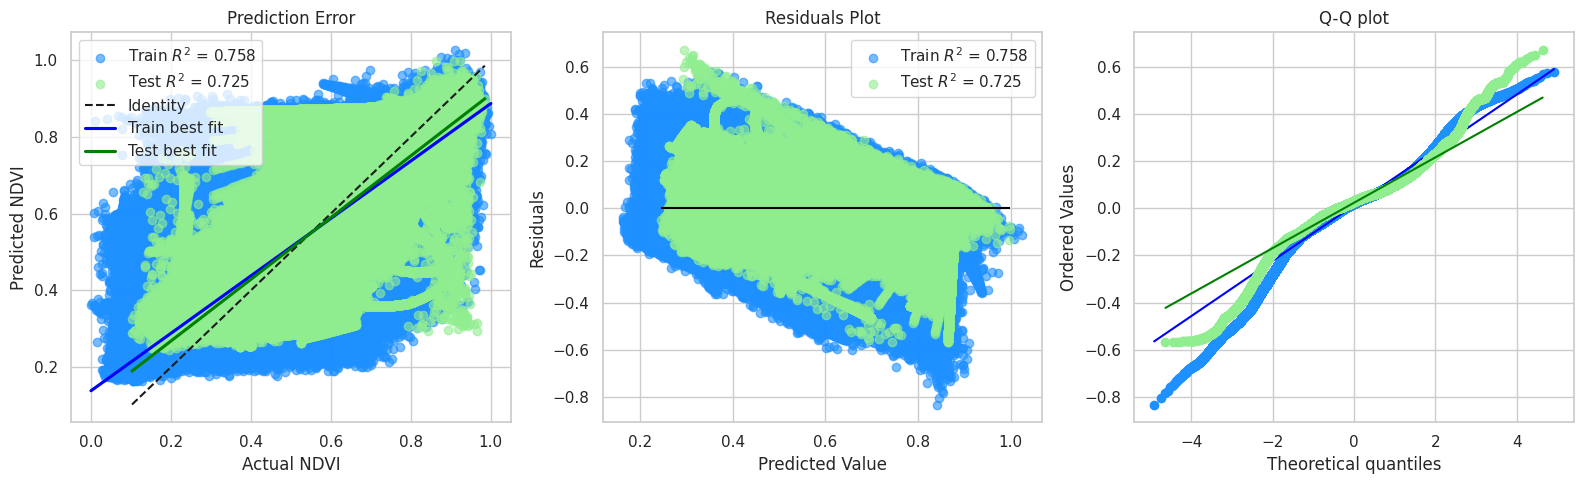

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats

# Optional: set style
sns.set(style="whitegrid")

# Compute residuals
train_residuals = y_train_true - y_train_pred
test_residuals = y_test_true - y_test_pred

# R2 scores
r2_train = r2_score(y_train_true, y_train_pred)
r2_test = r2_score(y_test_true, y_test_pred)

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# === Plot 1: Prediction Error ===
axes[0].scatter(y_train_true, y_train_pred, color='dodgerblue', alpha=0.6, label=f'Train $R^2$ = {r2_train:.3f}')
axes[0].scatter(y_test_true, y_test_pred, color='lightgreen', alpha=0.6, label=f'Test $R^2$ = {r2_test:.3f}')
axes[0].plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'k--', label='Identity')
sns.regplot(x=y_train_true, y=y_train_pred, scatter=False, ax=axes[0], color='blue', line_kws={"linestyle":"-"}, label="Train best fit")
sns.regplot(x=y_test_true, y=y_test_pred, scatter=False, ax=axes[0], color='green', line_kws={"linestyle":"-"}, label="Test best fit")
axes[0].set_title('Prediction Error')
axes[0].set_xlabel('Actual NDVI')
axes[0].set_ylabel('Predicted NDVI')
axes[0].legend()

# === Plot 2: Residuals Plot ===
axes[1].scatter(y_train_pred, train_residuals, color='dodgerblue', alpha=0.6, label=f'Train $R^2$ = {r2_train:.3f}')
axes[1].scatter(y_test_pred, test_residuals, color='lightgreen', alpha=0.6, label=f'Test $R^2$ = {r2_test:.3f}')
axes[1].hlines(0, min(y_test_pred), max(y_test_pred), colors='black')
axes[1].set_title('Residuals Plot')
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('Residuals')
axes[1].legend()

# === Plot 3: Q-Q Plot ===
stats.probplot(train_residuals, dist="norm", plot=axes[2])
axes[2].get_lines()[1].set_color('blue')  # QQ line
axes[2].get_lines()[0].set_markerfacecolor('dodgerblue')  # QQ points
axes[2].get_lines()[0].set_markeredgecolor('dodgerblue')
stats.probplot(test_residuals, dist="norm", plot=axes[2])
axes[2].get_lines()[3].set_color('green')  # QQ line for test
axes[2].get_lines()[2].set_markerfacecolor('lightgreen')  # QQ points for test
axes[2].get_lines()[2].set_markeredgecolor('lightgreen')
axes[2].set_title('Q-Q plot')

plt.tight_layout()
plt.savefig('ndvi_model_diagnostics.jpg', dpi=300)
plt.show()
